# 1. Comparable Groups - Clustering Students with KMeans Algorithm using and PCA in Scikit-learn

* **author** = Diego Sapunar-Opazo
* **copyright** = Copyright 2019, Thesis M.Sc. Diego Sapunar - Pontificia Universidad Católica de Chile
* **credits** = Diego Sapunar-Opazo, Ronald Perez, Mar Perez-Sanagustin, Jorge Maldonado-Mahauad
* **maintainer** = Diego Sapunar-Opazo
* **email** = dasapunar@uc.cl
* **status** = Dev

## Part 0: Import Packages

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
%matplotlib inline

# machine learning & models
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn import decomposition

## Part 1: Preparing the data

In [3]:
def merging(df1, df2, variable1, variable2):
    '''
    Merge df1 and df2 over the variable.
    
    Input:
    df1 - Pandas DataFrame
    df2 - Pandas DataFrame
    variable - String: name of the column to use as pivot.
    
    Output:
    Pandas DataFrame
    '''

    df1.dropna(inplace=True)
    df2.dropna(inplace=True)
    
    # getting same types
    df1[variable1] = df1[variable1].astype('str')
    df2[variable2] = df2[variable2].astype('str')
    
    return pd.merge(left=df1, right=df2, left_on=variable1, right_on=variable2)
    

In [4]:
def merging_normalizing(*dfs, variables_to_norm=[], primary_key=str()):
    '''
    Merge several pandas Dataframe, in order to be able to apply the clustering algorithm. First must be the SEC!
    
    Input:
    *dfs - list of dataframes to be merged.
    variables_to_norm - list of variables that need to be normalized (0 to 1).
    primary_key - string: the key where the dataframes are going to be merged.
    
    Output:
    The function will be printing the n size for each merging, in order to get bottle necks.
    df - pandas Dataframe ready for clustering
    '''
    
    # merging
    df = dfs[0]
    
    for i in range(1,len(dfs)):
        df = merging(df, dfs[i], primary_key, primary_key)
    # normalizing columns in the argument variables
    x = df.loc[:,variables_to_norm].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_norm = pd.DataFrame(x_scaled)
    
    return df_norm.rename({i:variables_to_norm[i] for i in range(len(variables_to_norm))}, axis=1).merge(df.iloc[:,[0,1]], left_index=True, right_index=True)

In [5]:
# getting the data
df_nf = pd.read_csv('../../data/final_data/performance.csv').iloc[:,[0,-1]]
df_GPA = pd.read_csv('../../data/clean_data/students_GPA.csv')
df_sec = pd.read_csv('../../data/clean_data/students_sec.csv')
df_interactions = pd.read_csv('../../data/final_data/coursera_students_interactions_nueva.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# feature extraction: get students' mean timespent in coursera by week
df_mean_timespent_week = df_interactions[['num_alumno', 'week', 'timespent']].groupby(['num_alumno', 'week']).sum()
df_mean_timespent_week = df_mean_timespent_week.unstack(0).fillna(0).mean().reset_index().rename({0: 'mean_timespent_week'},axis=1).iloc[:,[1,2]]

In [7]:
# merging and normalizing my data
df_norm = merging_normalizing(df_sec, df_nf, df_GPA, df_mean_timespent_week, variables_to_norm=['NF', 'GPA', 'mean_timespent_week'], primary_key='num_alumno')

In [8]:
# prev data
df_norm.head(3)

,NF,GPA,mean_timespent_week,num_alumno,sec
0,0.444444,0.308756,0.420891,14633000,1
1,0.518519,0.382488,0.372301,15639703,1
2,0.333333,0.216590,0.301075,13636456,1


## Part 2: Determining number of clusters

### (2.1) The “Elbow” Method

Probably the most well known method, the elbow method, in which the sum of squares at each number of clusters is calculated and graphed, and the user looks for a change of slope from steep to shallow (an elbow) to determine the optimal number of clusters. This method is inexact, but still potentially helpful.


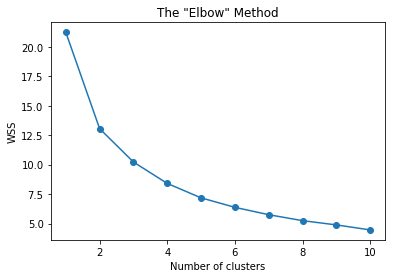

In [9]:
# calculate distortion for a range of number of cluster

NUMBER_FEATURES = 3  # features for clustering

distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_norm.iloc[:,0:NUMBER_FEATURES])
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.title('The "Elbow" Method')
plt.show()

### (2.2) The Silhouette Method

Another visualization that can help determine the optimal number of clusters is called the a silhouette method. Average silhouette method computes the average silhouette of observations for different values of k. The optimal number of clusters k is the one that maximize the average silhouette over a range of possible values for k.

For n_clusters = 2 The average silhouette_score is: 0.32
For n_clusters = 3 The average silhouette_score is: 0.3
For n_clusters = 4 The average silhouette_score is: 0.27
For n_clusters = 5 The average silhouette_score is: 0.27
For n_clusters = 6 The average silhouette_score is: 0.25
For n_clusters = 7 The average silhouette_score is: 0.25


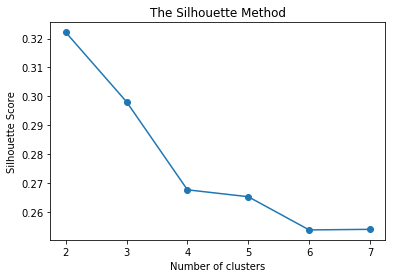

In [10]:
sil = []
for n_clusters in range(2, 8):
    clusterer = KMeans(n_clusters=n_clusters, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)
    y = clusterer.fit_predict(df_norm.iloc[:,0:NUMBER_FEATURES])

    message = "For n_clusters = {} The average silhouette_score is: {}"
    print(message.format(n_clusters, round(silhouette_score(df_norm.iloc[:,0:NUMBER_FEATURES], y), 2)))
    sil.append(round(silhouette_score(df_norm.iloc[:,0:NUMBER_FEATURES], y), 4))



# plot
plt.plot(range(2, 8), sil, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('The Silhouette Method')
plt.show()

## Part 3: KMeans

In [11]:
# getting clusters
NUMBER_CLUSTERS = 3
Kmean = KMeans(
    n_clusters=NUMBER_CLUSTERS, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
)
Kmean.fit(df_norm.iloc[:,0:NUMBER_FEATURES])

df_norm['cluster'] = pd.Series(Kmean.labels_)

Text(0.5, 0, 'Course engagement')

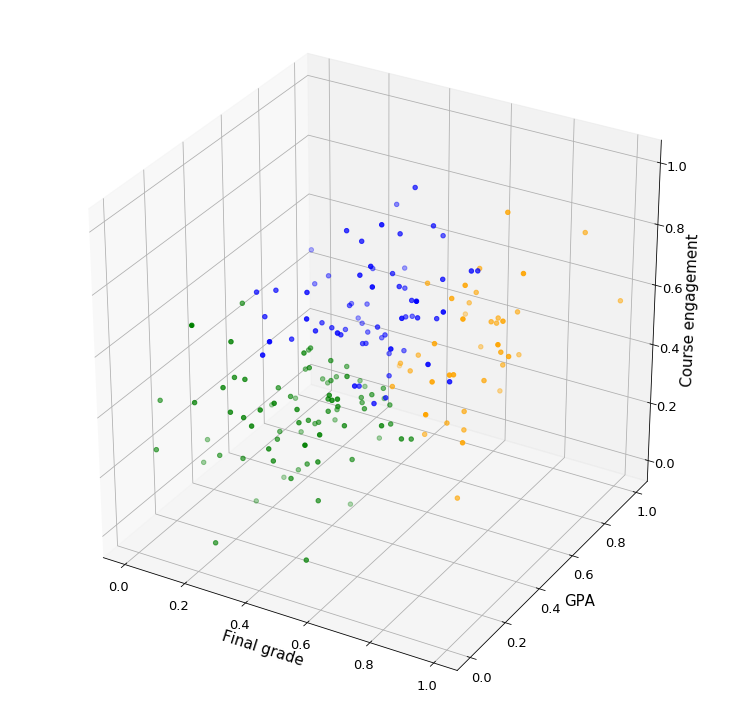

In [14]:
# Visualizing
# spliting data for coloring
df0 = df_norm[df_norm['cluster'] == 0]
df1 = df_norm[df_norm['cluster'] == 1]
df2 = df_norm[df_norm['cluster'] == 2]


# building the figure
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')

# visualizing
ax.scatter(df0['NF'], df0['GPA'], df0['mean_timespent_week'], c='blue', marker='o')
ax.scatter(df1['NF'], df1['GPA'], df1['mean_timespent_week'], c='orange', marker='o')
ax.scatter(df2['NF'], df2['GPA'], df2['mean_timespent_week'], c='green', marker='o')

# setting params styles
ax.tick_params(axis='both', which='major', labelsize=13)

# setting axes labels
ax.set_xlabel('Final grade', fontsize=15)
ax.set_ylabel('GPA', fontsize=15)
ax.set_zlabel('Course engagement', fontsize=15)

# setting legend
# ax.legend(['Cluster 0','Cluster 1', 'Cluster 2'], loc='best', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')

## Part 4: Understanding Clusters

### (4.1) PCA

shape of pca_reduced.shape =  (188, 2)


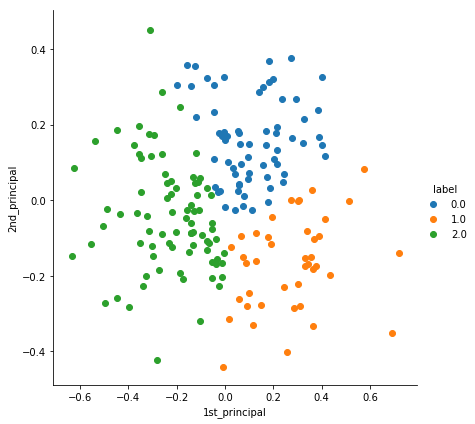

In [73]:
#initializing PCA
pca = decomposition.PCA()

#set number of parameter as 2
pca.n_components = 2
pca_data = pca.fit_transform(df_norm.iloc[:,0:NUMBER_FEATURES])

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)

# attaching the label for each 2-d data point
pca_data = np.vstack((pca_data.T, Kmean.labels_)).T
# creating a new data from which help us in plotting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sns.FacetGrid(pca_df, hue="label", height=6).map(plt.scatter, "1st_principal", "2nd_principal").add_legend()
plt.show()


### These principal components are calculated only from features and no information from classes are considered. So PCA is unsupervised method and it’s difficult to interpret the two axes as they are some complex mixture of the original features.

We can make a heat-plot to see how the features mixed up to create the components.

### (4.2) Labeling Clusters

In [79]:
df_labeling = pd.merge(left=df_norm, right=df_nf.rename({'NF':'NF_labeling'},axis=1), left_on='num_alumno', right_on='num_alumno')
df_labeling = pd.merge(left=df_labeling, right=df_GPA.rename({'GPA':'GPA_labeling'},axis=1), left_on='num_alumno', right_on='num_alumno')
df_labeling = pd.merge(left=df_labeling, right=df_mean_timespent_week.rename({'mean_timespent_week':'TS_labeling'},axis=1), left_on='num_alumno', right_on='num_alumno')

#### cluster 0 : BLUE

Text(0.5, 0, 'MEAN TIMESPENT COURSERA')

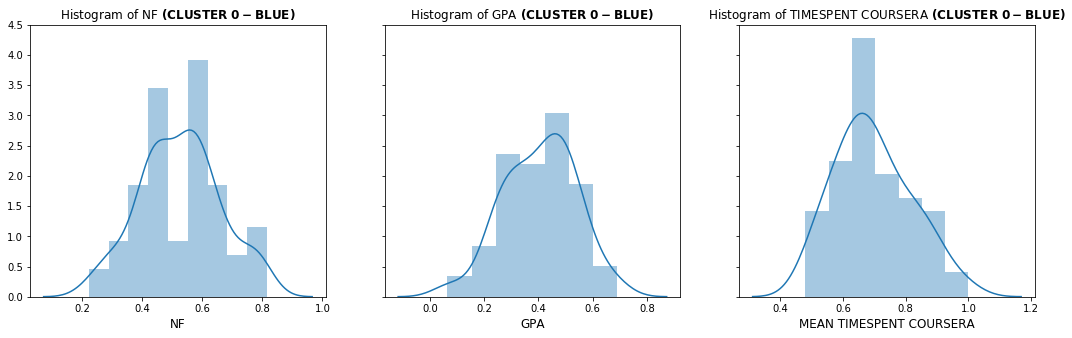

In [80]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(18, 5))

# Set plots
axs[0] = sns.distplot(df0['NF'], kde = True, ax=axs[0])
axs[1] = sns.distplot(df0['GPA'], kde = True, ax=axs[1])
axs[2] = sns.distplot(df0['mean_timespent_week'], kde = True, ax=axs[2])


# Set titles
axs[0].set_title("Histogram of NF " + r"$\bf{(CLUSTER}$" + " " + r"$\bf{0-BLUE)}$")
axs[1].set_title("Histogram of GPA " + r"$\bf{(CLUSTER}$" + " " + r"$\bf{0-BLUE)}$")
axs[2].set_title("Histogram of TIMESPENT COURSERA " + r"$\bf{(CLUSTER}$" + " " + r"$\bf{0-BLUE)}$")
# axs[3].set_title("Histogram of TIMESPENT COURSERA " + r"$\bf{(CLUSTER}$" + " " + r"$\bf{0-AZUL)}$")


# Set X Label
axs[0].set_xlabel('NF', fontsize=12)
axs[1].set_xlabel('GPA', fontsize=12)
axs[2].set_xlabel('MEAN TIMESPENT COURSERA', fontsize=12)

#### Cluster 1: ORANGE

Text(0.5, 0, 'MEAN TIMESPENT COURSERA')

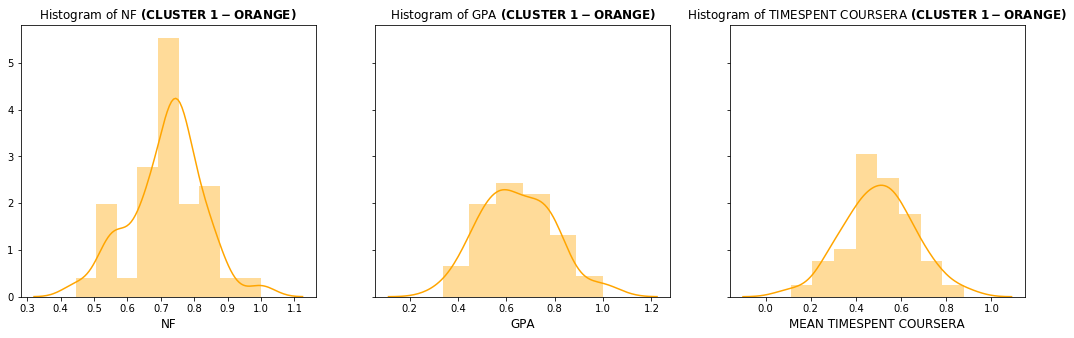

In [81]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(18, 5))

# Set plots
axs[0] = sns.distplot(df1['NF'], color='orange', kde = True, ax=axs[0])
axs[1] = sns.distplot(df1['GPA'], kde = True, color='orange', ax=axs[1])
axs[2] = sns.distplot(df1['mean_timespent_week'], kde = True, color='orange', ax=axs[2])

# Set titles
axs[0].set_title("Histogram of NF " + r"$\bf{(CLUSTER}$" + " " + r"$\bf{1-ORANGE)}$")
axs[1].set_title("Histogram of GPA " + r"$\bf{(CLUSTER}$" + " " + r"$\bf{1-ORANGE)}$")
axs[2].set_title("Histogram of TIMESPENT COURSERA " + r"$\bf{(CLUSTER}$" + " " + r"$\bf{1-ORANGE)}$")

# Set X Label
axs[0].set_xlabel('NF', fontsize=12)
axs[1].set_xlabel('GPA', fontsize=12)
axs[2].set_xlabel('MEAN TIMESPENT COURSERA', fontsize=12)

#### Cluster 2: GREEN

Text(0.5, 0, 'MEAN TIMESPENT COURSERA')

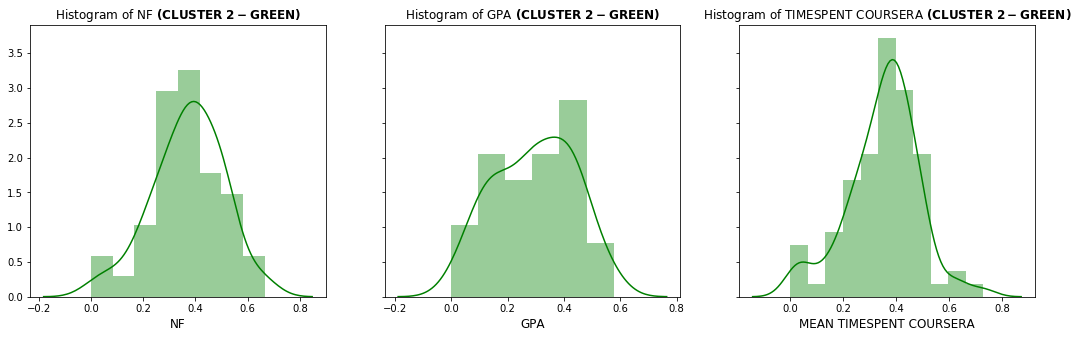

In [76]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(18, 5))

# Set plots
axs[0] = sns.distplot(df2['NF'], color='green', kde = True, ax=axs[0])
axs[1] = sns.distplot(df2['GPA'], kde = True, color='green', ax=axs[1])
axs[2] = sns.distplot(df2['mean_timespent_week'], kde = True, color='green', ax=axs[2])

# Set titles
axs[0].set_title("Histogram of NF " + r"$\bf{(CLUSTER}$" + " " + r"$\bf{2-GREEN)}$")
axs[1].set_title("Histogram of GPA " + r"$\bf{(CLUSTER}$" + " " + r"$\bf{2-GREEN)}$")
axs[2].set_title("Histogram of TIMESPENT COURSERA " + r"$\bf{(CLUSTER}$" + " " + r"$\bf{2-GREEN)}$")

# Set X Label
axs[0].set_xlabel('NF', fontsize=12)
axs[1].set_xlabel('GPA', fontsize=12)
axs[2].set_xlabel('MEAN TIMESPENT COURSERA', fontsize=12)

#### Getting stats of each cluster

In [77]:
data = {'Feature': ['GPA','NF','TIMESPENT COURSERA'],
        'Blue-mean': [df_labeling[df_labeling['cluster'] == 0]['GPA_labeling'].mean(), 
                      df_labeling[df_labeling['cluster'] == 0]['NF_labeling'].mean(), 
                      df_labeling[df_labeling['cluster'] == 0]['TS_labeling'].mean()],
       'Blue-std': [df_labeling[df_labeling['cluster'] == 0]['GPA_labeling'].std(), 
                    df_labeling[df_labeling['cluster'] == 0]['NF_labeling'].std(), 
                    df_labeling[df_labeling['cluster'] == 0]['TS_labeling'].std()],
        
        
        'Orange-mean': [df_labeling[df_labeling['cluster'] == 1]['GPA_labeling'].mean(), 
                        df_labeling[df_labeling['cluster'] == 1]['NF_labeling'].mean(), 
                        df_labeling[df_labeling['cluster'] == 1]['TS_labeling'].mean()],
       'Orange-std': [df_labeling[df_labeling['cluster'] == 1]['GPA_labeling'].std(), 
                      df_labeling[df_labeling['cluster'] == 1]['NF_labeling'].std(), 
                      df_labeling[df_labeling['cluster'] == 1]['TS_labeling'].std()],
        
        
        'Green-mean': [df_labeling[df_labeling['cluster'] == 2]['GPA_labeling'].mean(), 
                        df_labeling[df_labeling['cluster'] == 2]['NF_labeling'].mean(), 
                        df_labeling[df_labeling['cluster'] == 2]['TS_labeling'].mean()],
       'Green-std': [df_labeling[df_labeling['cluster'] == 2]['GPA_labeling'].std(), 
                      df_labeling[df_labeling['cluster'] == 2]['NF_labeling'].std(), 
                      df_labeling[df_labeling['cluster'] == 2]['TS_labeling'].std()],

       }
pd.DataFrame.from_dict(data).set_index('Feature')

,Blue-mean,Blue-std,Orange-mean,Orange-std,Green-mean,Green-std
Feature,,,,,,
GPA,4.827048,0.299740,5.369765,0.339506,NaN,NaN
NF,5.156190,0.376963,5.814118,0.381773,NaN,NaN
TIMESPENT COURSERA,3114.178401,1304.583961,4737.005264,1339.732927,NaN,NaN


In [78]:
# normalized for cheching
data = {'Feature': ['GPA','NF','TIMESPENT COURSERA'],
        'Blue-mean': [df_labeling[df_labeling['cluster'] == 0]['GPA'].mean(), 
                      df_labeling[df_labeling['cluster'] == 0]['NF'].mean(), 
                      df_labeling[df_labeling['cluster'] == 0]['mean_timespent_week'].mean()],
       'Blue-std': [df_labeling[df_labeling['cluster'] == 0]['GPA'].std(), 
                    df_labeling[df_labeling['cluster'] == 0]['NF'].std(), 
                    df_labeling[df_labeling['cluster'] == 0]['mean_timespent_week'].std()],
        
        
        'Orange-mean': [df_labeling[df_labeling['cluster'] == 1]['GPA'].mean(), 
                        df_labeling[df_labeling['cluster'] == 1]['NF'].mean(), 
                        df_labeling[df_labeling['cluster'] == 1]['mean_timespent_week'].mean()],
       'Orange-std': [df_labeling[df_labeling['cluster'] == 1]['GPA'].std(), 
                      df_labeling[df_labeling['cluster'] == 1]['NF'].std(), 
                      df_labeling[df_labeling['cluster'] == 1]['mean_timespent_week'].std()],
        
        
        'Green-mean': [df_labeling[df_labeling['cluster'] == 2]['GPA'].mean(), 
                        df_labeling[df_labeling['cluster'] == 2]['NF'].mean(), 
                        df_labeling[df_labeling['cluster'] == 2]['mean_timespent_week'].mean()],
       'Green-std': [df_labeling[df_labeling['cluster'] == 2]['GPA'].std(), 
                      df_labeling[df_labeling['cluster'] == 2]['NF'].std(), 
                      df_labeling[df_labeling['cluster'] == 2]['mean_timespent_week'].std()],

       }
pd.DataFrame.from_dict(data).set_index('Feature')

,Blue-mean,Blue-std,Orange-mean,Orange-std,Green-mean,Green-std
Feature,,,,,,
GPA,0.298179,0.138129,0.548279,0.156454,NaN,NaN
NF,0.391182,0.139616,0.634858,0.141397,NaN,NaN
TIMESPENT COURSERA,0.399991,0.176633,0.630823,0.165271,NaN,NaN


## Part 5: Export Data

In [92]:
df_norm.loc[:,['num_alumno', 'cluster']].to_csv('../../data/final_data/students_clusters.csv', index=False)